In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [14]:
fullDf = pd.read_csv('../Processed Datasets/globalTemp.csv', parse_dates=['date'])
fullDf.head()

,AvgTemp,date
0,3.034,1750-01-01
1,3.083,1750-02-01
2,5.626,1750-03-01
3,8.490,1750-04-01
4,11.573,1750-05-01


In [15]:
fullDf.set_index("date", inplace=True)
fullDf = fullDf['1970':]
fullDf.head()

,AvgTemp
date,
1970-01-01,2.836
1970-01-02,3.735
1970-01-03,5.272
1970-01-04,8.603
1970-01-05,11.206


<AxesSubplot:xlabel='date'>

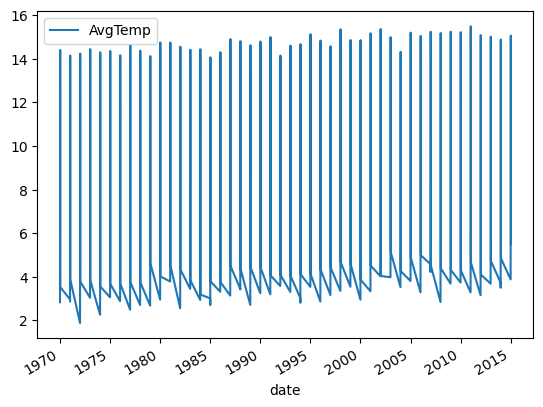

In [16]:
fullDf.plot()

In [17]:
from statsmodels.tsa.stattools import adfuller

def adf_test(timeseries):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag = 'AIC')
    dfoutput = pd.Series(dftest[0:4], index = ['Test Statistic','p-value','No. of Lags Used',
                                             'Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
adf_test(fullDf["AvgTemp"])

Results of Dickey-Fuller Test:
Test Statistic                  -2.093440
p-value                          0.247161
No. of Lags Used                15.000000
Number of Observations Used    536.000000
Critical Value (1%)             -3.442609
Critical Value (5%)             -2.866947
Critical Value (10%)            -2.569650
dtype: float64


<AxesSubplot:xlabel='date'>

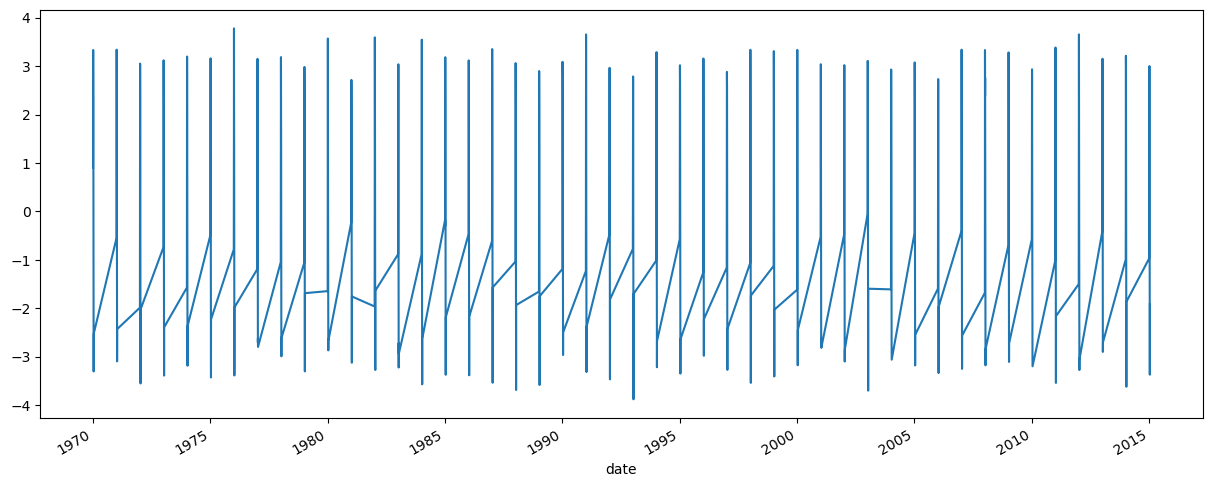

In [18]:
fullDf["AvgTemp"] = pd.Series(fullDf["AvgTemp"]).diff()
fullDf.dropna(inplace=True)
fullDf.plot(figsize = (15, 6), legend = None)

In [19]:
adf_test(fullDf["AvgTemp"])

Results of Dickey-Fuller Test:
Test Statistic                -7.241537e+00
p-value                        1.878751e-10
No. of Lags Used               1.900000e+01
Number of Observations Used    5.310000e+02
Critical Value (1%)           -3.442725e+00
Critical Value (5%)           -2.866998e+00
Critical Value (10%)          -2.569677e+00
dtype: float64


In [26]:
y = fullDf['AvgTemp']
y.head()

date
1970-01-02    0.899
1970-01-03    1.537
1970-01-04    3.331
1970-01-05    2.603
1970-01-06    2.307
Name: AvgTemp, dtype: float64

In [34]:
train = y[:int(0.8*(len(y)))]
test = y[int(0.8*(len(y))):]

In [36]:
from pmdarima.arima import auto_arima

#The default values of several important parameters for auto_arima function are as follows:
#max_p=5, max_d=2, max_q=5, max_P=2, max_D=1, max_Q=2

arima_model = auto_arima(train, seasonal = True, m = 12, stepwise = False, trace = 0, random_state = 10)

In [37]:
import statsmodels.api as sm

model = sm.tsa.statespace.SARIMAX(train, order = (0, 0, 1), seasonal_order = (1, 0, 1, 12), 
                                  enforce_stationarity = False, enforce_invertibility = False)
fitted_model = model.fit(maxiter = 200, method = 'nm')
print(fitted_model.summary())

d:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
d:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


Optimization terminated successfully.
         Current function value: 0.235180
         Iterations: 185
         Function evaluations: 313
                                     SARIMAX Results                                      
Dep. Variable:                            AvgTemp   No. Observations:                  440
Model:             SARIMAX(0, 0, 1)x(1, 0, 1, 12)   Log Likelihood                -103.479
Date:                            Mon, 05 Dec 2022   AIC                            214.958
Time:                                    22:29:24   BIC                            231.176
Sample:                                         0   HQIC                           221.365
                                            - 440                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------

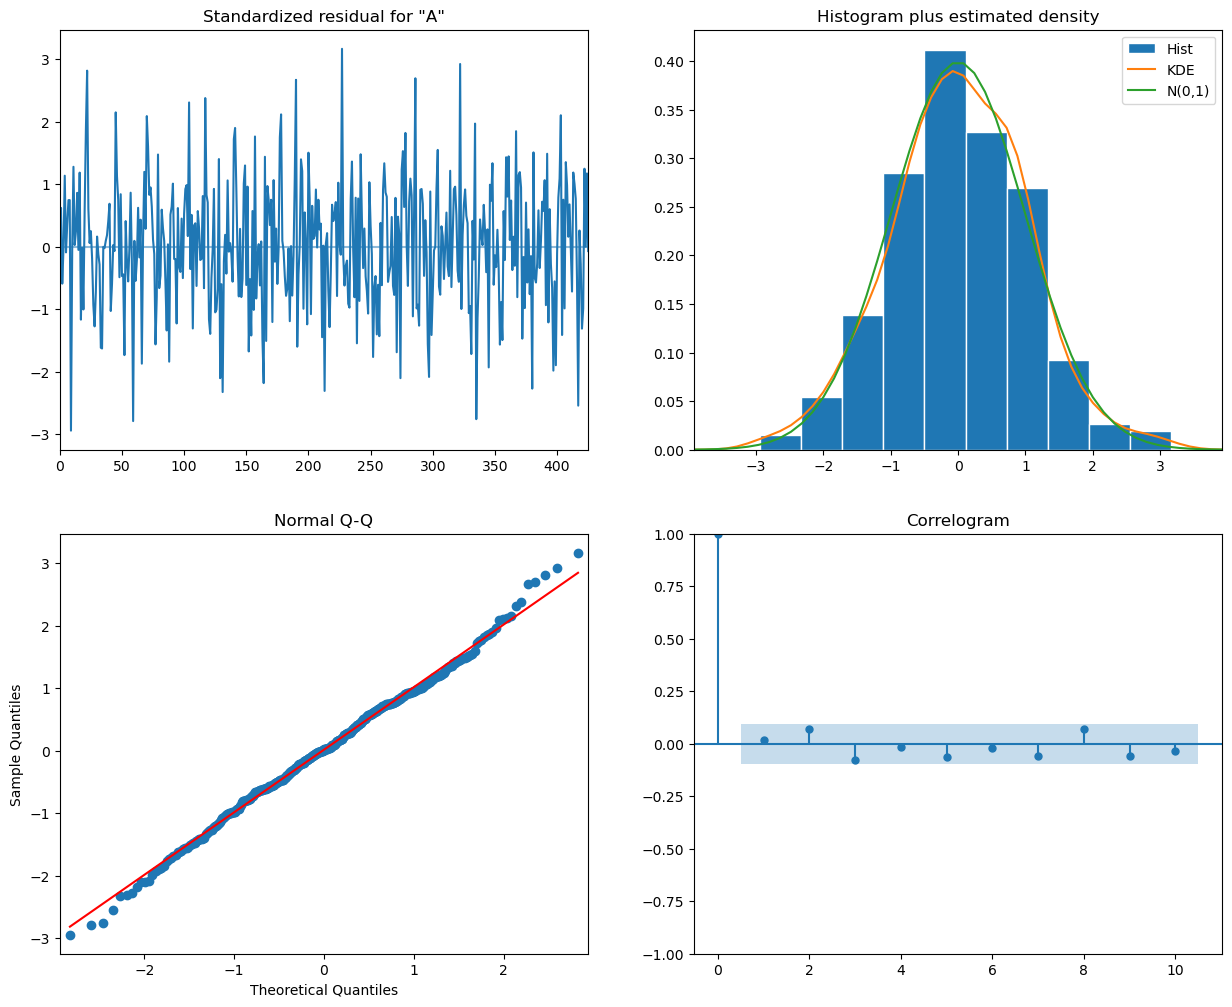

In [38]:
fitted_model.plot_diagnostics(figsize = (15, 12))
plt.show()

d:\Anaconda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


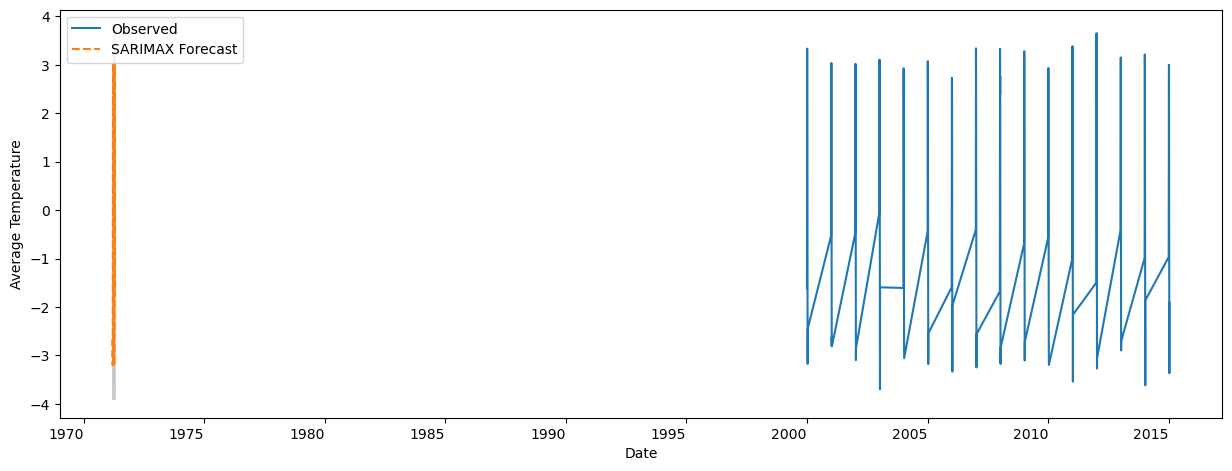

In [39]:
#Getting the SARIMAX forecast with number of steps as 36 since we want to make 3 year prediction and our data is monthly sampled.
pred = fitted_model.get_forecast(steps = 36)
#Plotting the observed and forecasted values:
ax1 = y['2000':].plot(label = 'Observed')
pred.predicted_mean.plot(ax = ax1, label = 'SARIMAX Forecast', figsize = (15, 6), linestyle = 'dashed')
#Finding the confidence intervals of the forecasts.
pred_ci = pred.conf_int()
ax1.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color = 'k', alpha = 0.2)
ax1.set_xlabel('Date')
ax1.set_ylabel('Average Temperature')
plt.legend(loc = 'upper left')
plt.show()

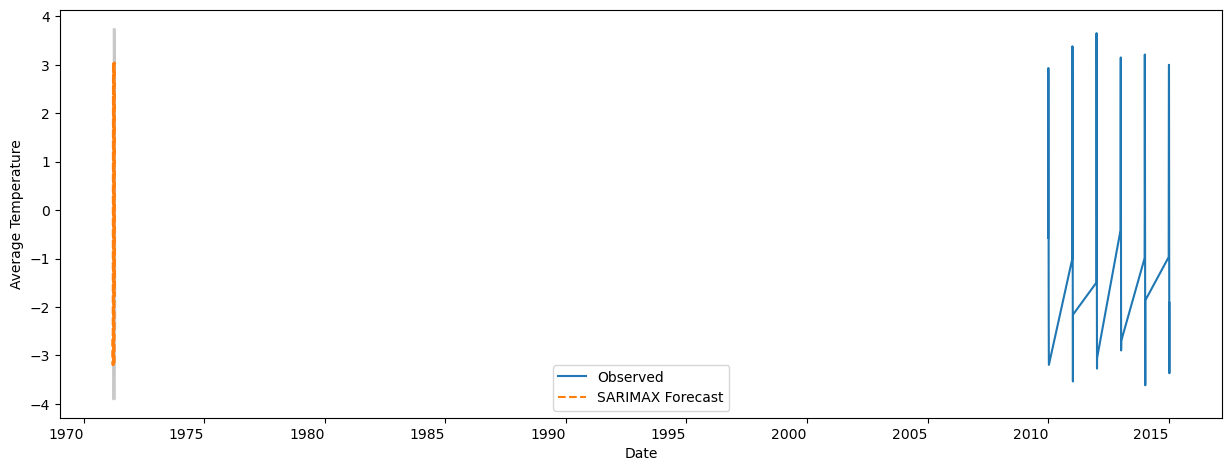

In [40]:
#Plotting the observed and forecasted values:
ax2 = y['2010':].plot(label = 'Observed')
pred.predicted_mean.plot(ax = ax2, label = 'SARIMAX Forecast', figsize = (15, 6), linestyle = 'dashed')
#Finding the confidence intervals of the forecasts.
pred_ci = pred.conf_int()
ax2.fill_between(pred_ci.index, pred_ci.iloc[:, 0], pred_ci.iloc[:, 1], color = 'k', alpha = 0.2)
ax2.set_xlabel('Date')
ax2.set_ylabel('Average Temperature')
plt.legend()
plt.show()

In [41]:
y_forecasted_SARIMAX = pred.predicted_mean
y_truth = test
mse_SARIMAX = ((y_forecasted_SARIMAX - y_truth) ** 2).mean()
print('The Mean Squared Error of SARIMAX forecast is {}'.format(round(mse_SARIMAX, 2)))
print('The Root Mean Squared Error of SARIMAX forecast is {}'.format(round(np.sqrt(mse_SARIMAX), 2)))

The Mean Squared Error of SARIMAX forecast is nan
The Root Mean Squared Error of SARIMAX forecast is nan
